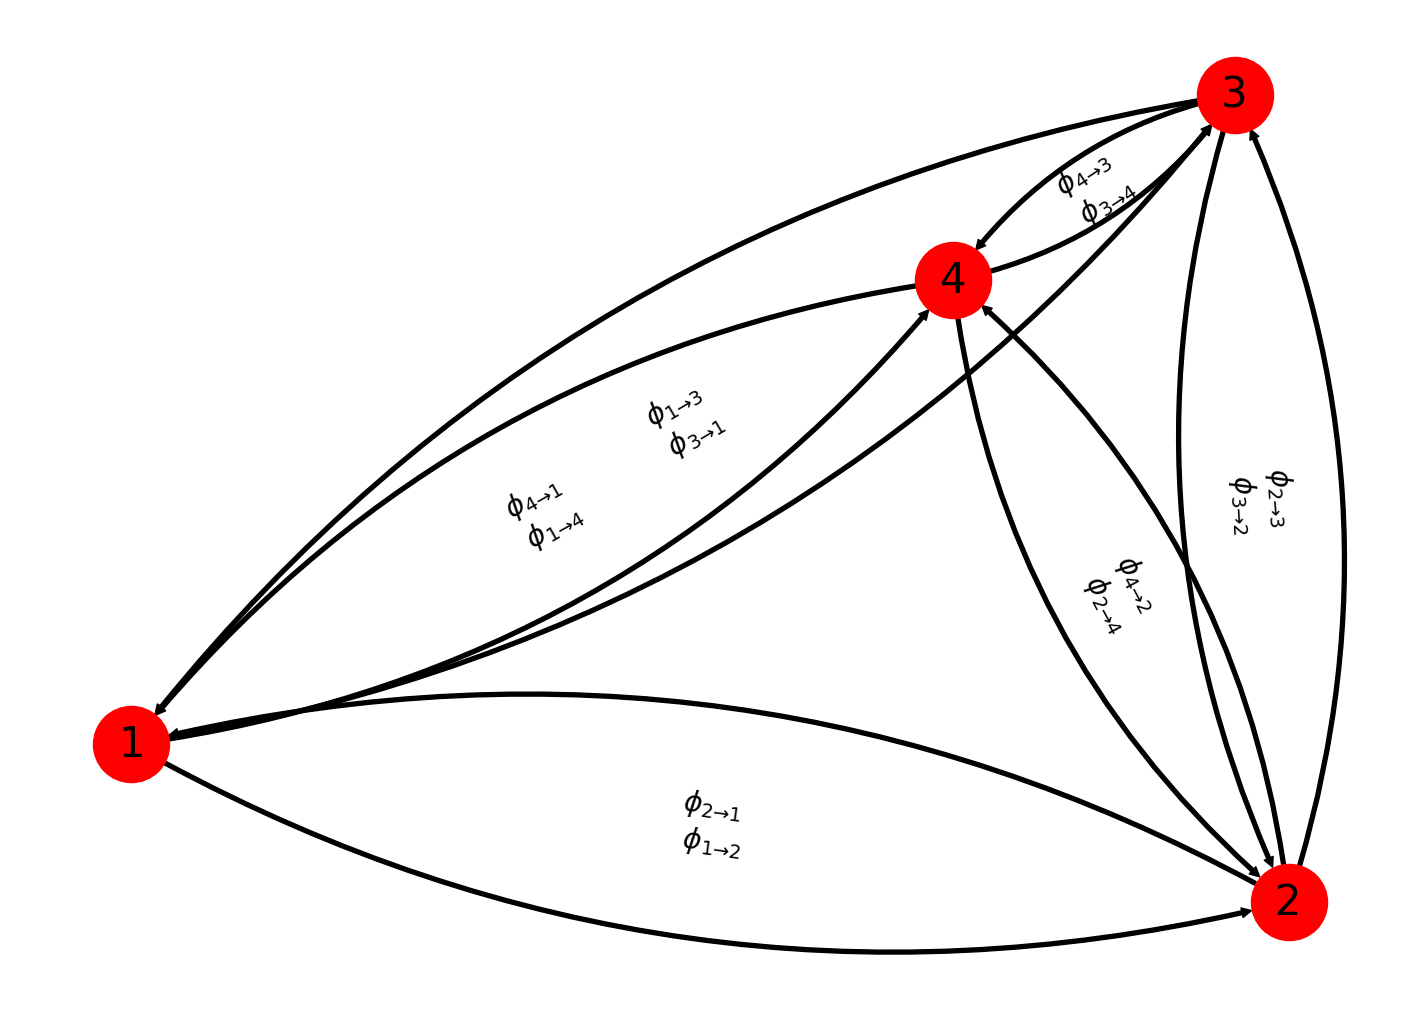

In [2]:
# Building the graph with nodes = 4

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(directed=True)
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)

G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)

G.add_edge(2, 1)
G.add_edge(2, 3)
G.add_edge(2, 4)

G.add_edge(3, 1)
G.add_edge(3, 2)
G.add_edge(3, 4)

G.add_edge(4, 1)
G.add_edge(4, 2)
G.add_edge(4, 3)

pos = {1: [-4.5, 1.0],
      2: [0.43, 0.153],
      3: [0.2, 4.5],
      4: [-1.0, 3.5]}


edge_labels = {(1, 2): '$\\phi_{2\\to 1}$\n $\\phi_{1\\to 2}$',
              (1, 3): '$\\phi_{1\\to 3}$\n $\\phi_{3\\to 1}$',
              (1, 4): '$\\phi_{4\\to 1}$\n $\\phi_{1\\to 4}$',
              (2, 3): '$\\phi_{2\\to 3}$\n $\\phi_{3\\to 2}$',
              (2, 4): '$\\phi_{4\\to 2}$\n $\\phi_{2\\to 4}$',
              (3, 4): '$\\phi_{4\\to 3}$\n $\\phi_{3\\to 4}$'
              }

fig = plt.figure(1, figsize=(14, 10)) 
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos=pos, connectionstyle='arc3, rad = 0.2', 
        node_size=3000, arrowsize=14, arrowstyle='simple', font_size=30)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20, bbox=dict(alpha=0))
 
plt.show()

In [4]:
# Lets import all the necessary libraries
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT
from numpy import pi

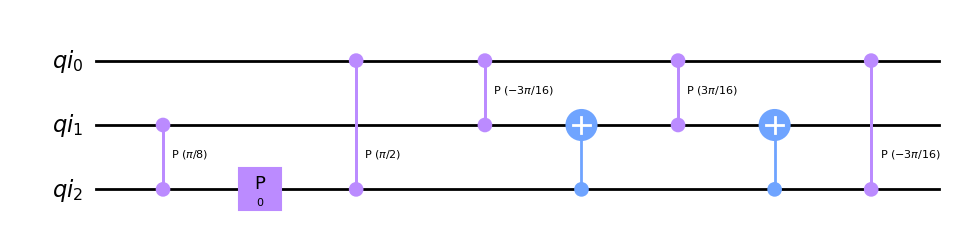

In [5]:
ai = 0
bi = pi/2
ci = pi/8
di = pi/4

qi = QuantumRegister(3, 'qi')
qci = QuantumCircuit(qi)


qci.cp(ci - ai, qi[2], qi[1])
qci.p(ai, qi[2])
qci.cp(bi - ai, qi[2], qi[0])

qci.cp((di - ci + ai - bi)/2, qi[1], qi[0])
qci.cx(qi[2], qi[1])
qci.cp(-(di - ci + ai - bi)/2, qi[1], qi[0])
qci.cx(qi[2], qi[1])
qci.cp((di - ci + ai - bi)/2, qi[2], qi[0])

qci.draw()

In [6]:
backend_unitary_i = Aer.get_backend('unitary_simulator')
job_unitary_i = execute(qci, backend_unitary_i, shots=8192)
count_unitary_i = job_unitary_i.result().get_unitary()
array_to_latex(count_unitary_i, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

In [7]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

In [8]:
def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0] ]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0] ]+eigen[2:4], [phases[3] ]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0] ]+eigen[4:6], phases[6:8]+[0]+[phases[8] ])
    controlled_unitary(qc, [unit[0] ]+eigen[6:8], phases[9:12]+[0])

In [9]:
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

In [10]:
# Storing the eigenvalues in a list
eigen_values = ["11000110", "10001101","11001001","10000111", "01001110", "01001011"]

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if eigen_values[index][i] == '1':
            qc.x(eigen[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc

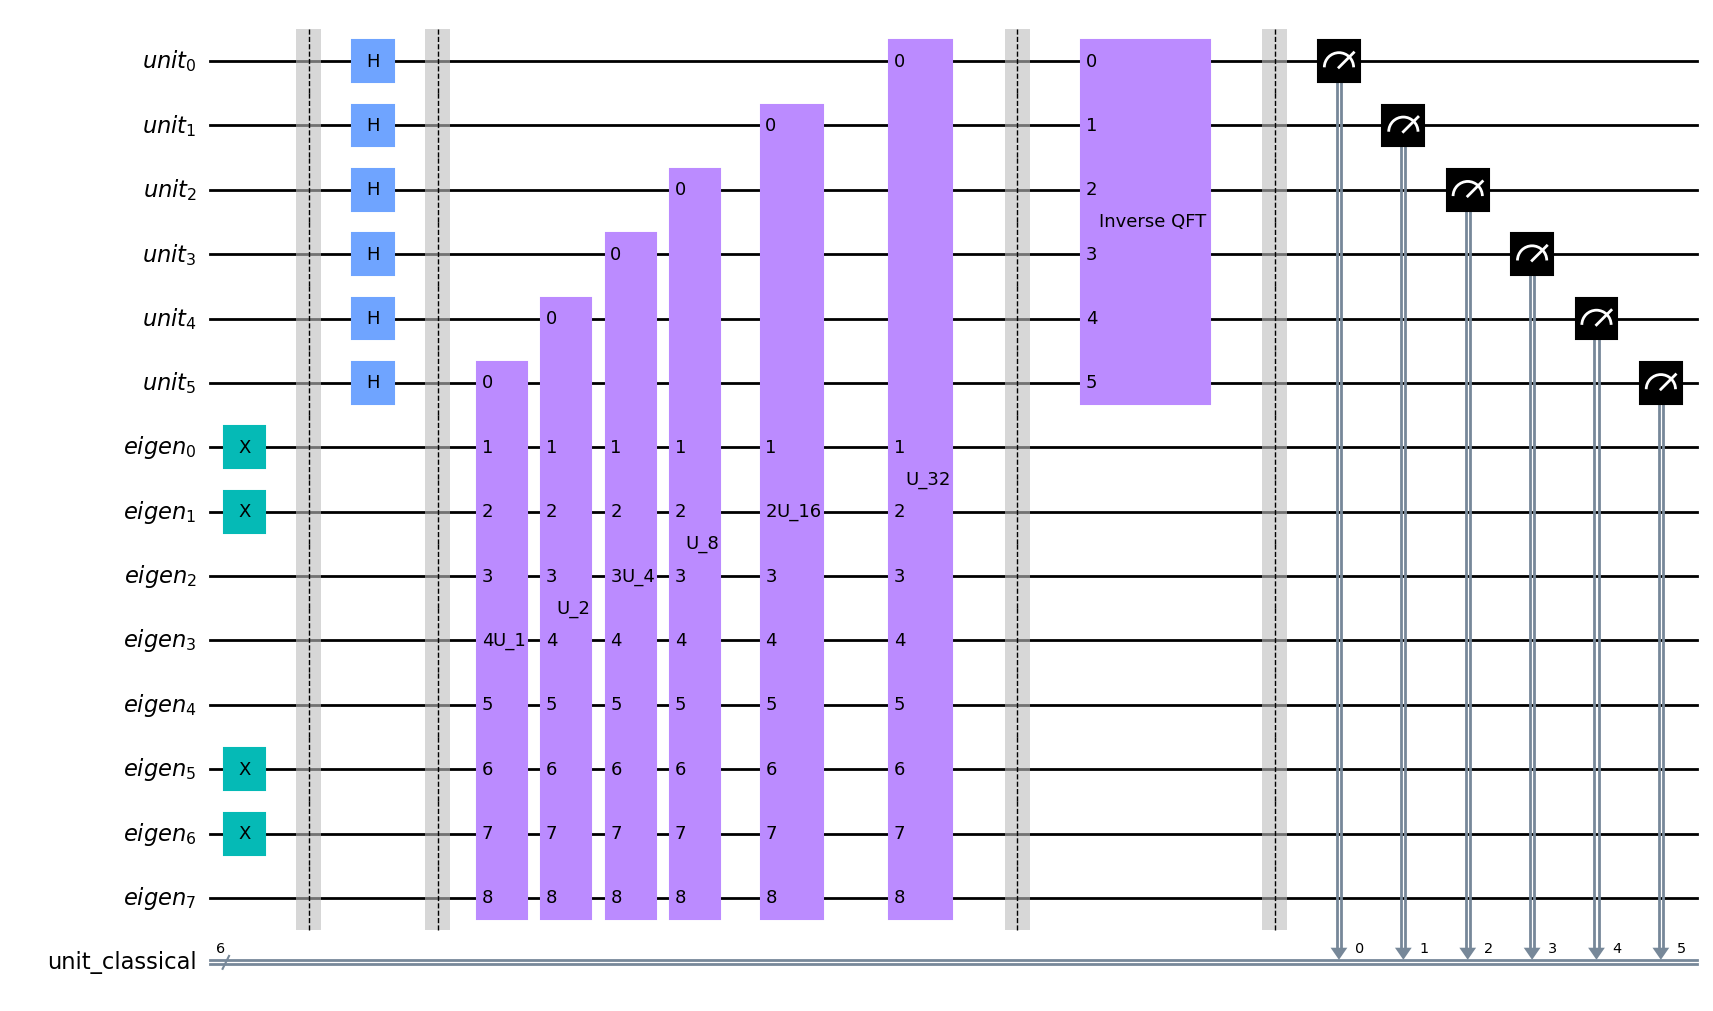

In [11]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 0)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i] ] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'100100': 8192}


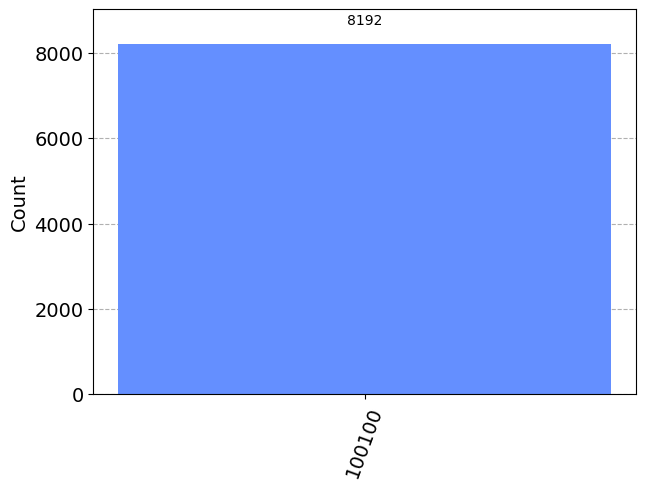

In [12]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)

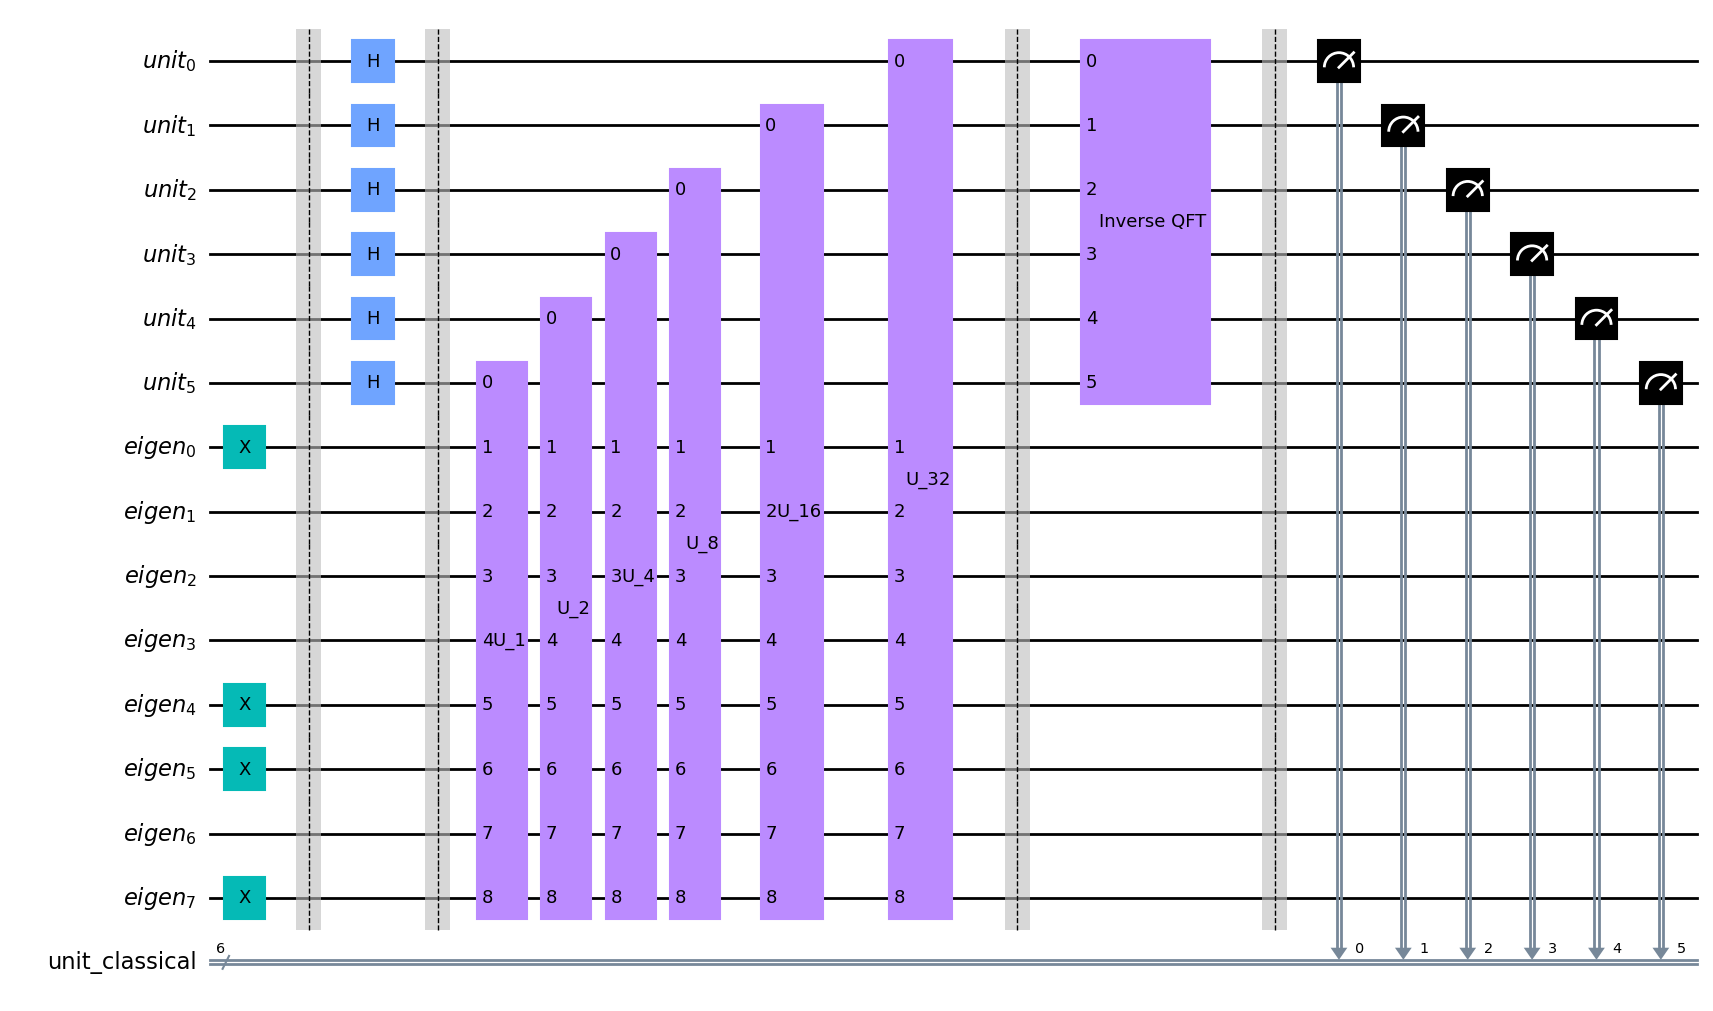

In [12]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 1)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, -pi / 2, pi / 4, pi / 4, -pi / 8, -pi / 4, pi / 8, -pi / 4, -pi / 4, -pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i] ] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'110000': 8192}


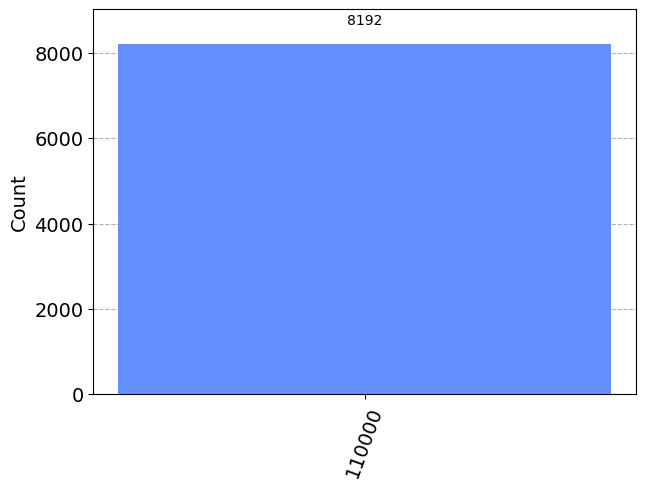

In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)

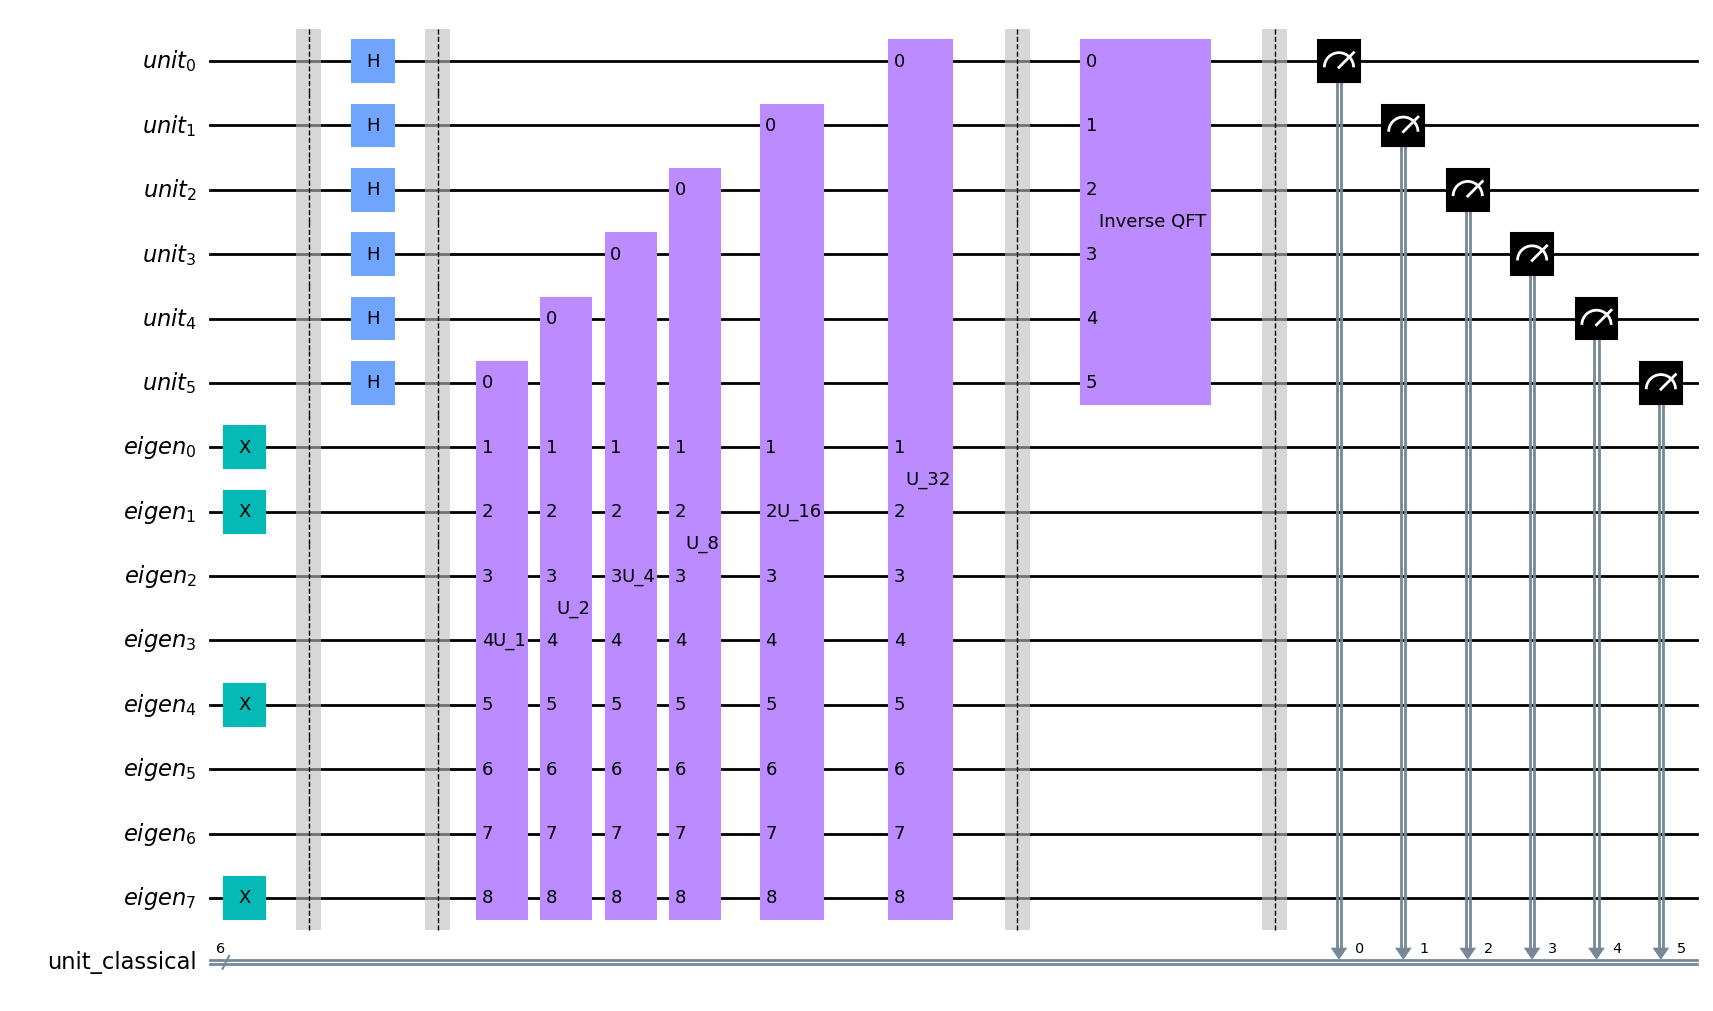

In [14]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 2)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i] ] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'100000': 8192}


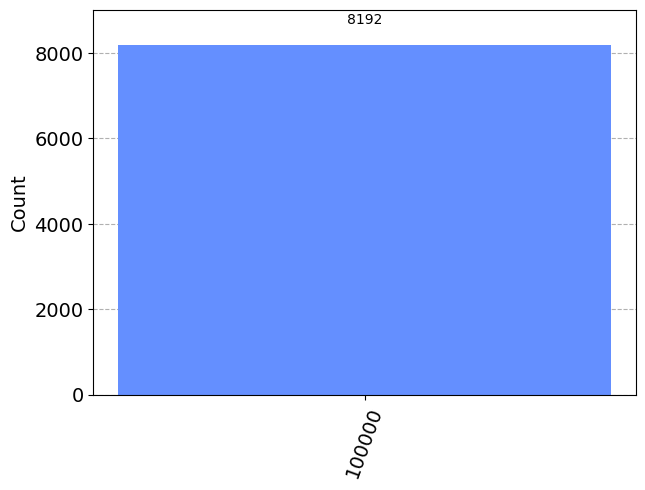

In [15]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)

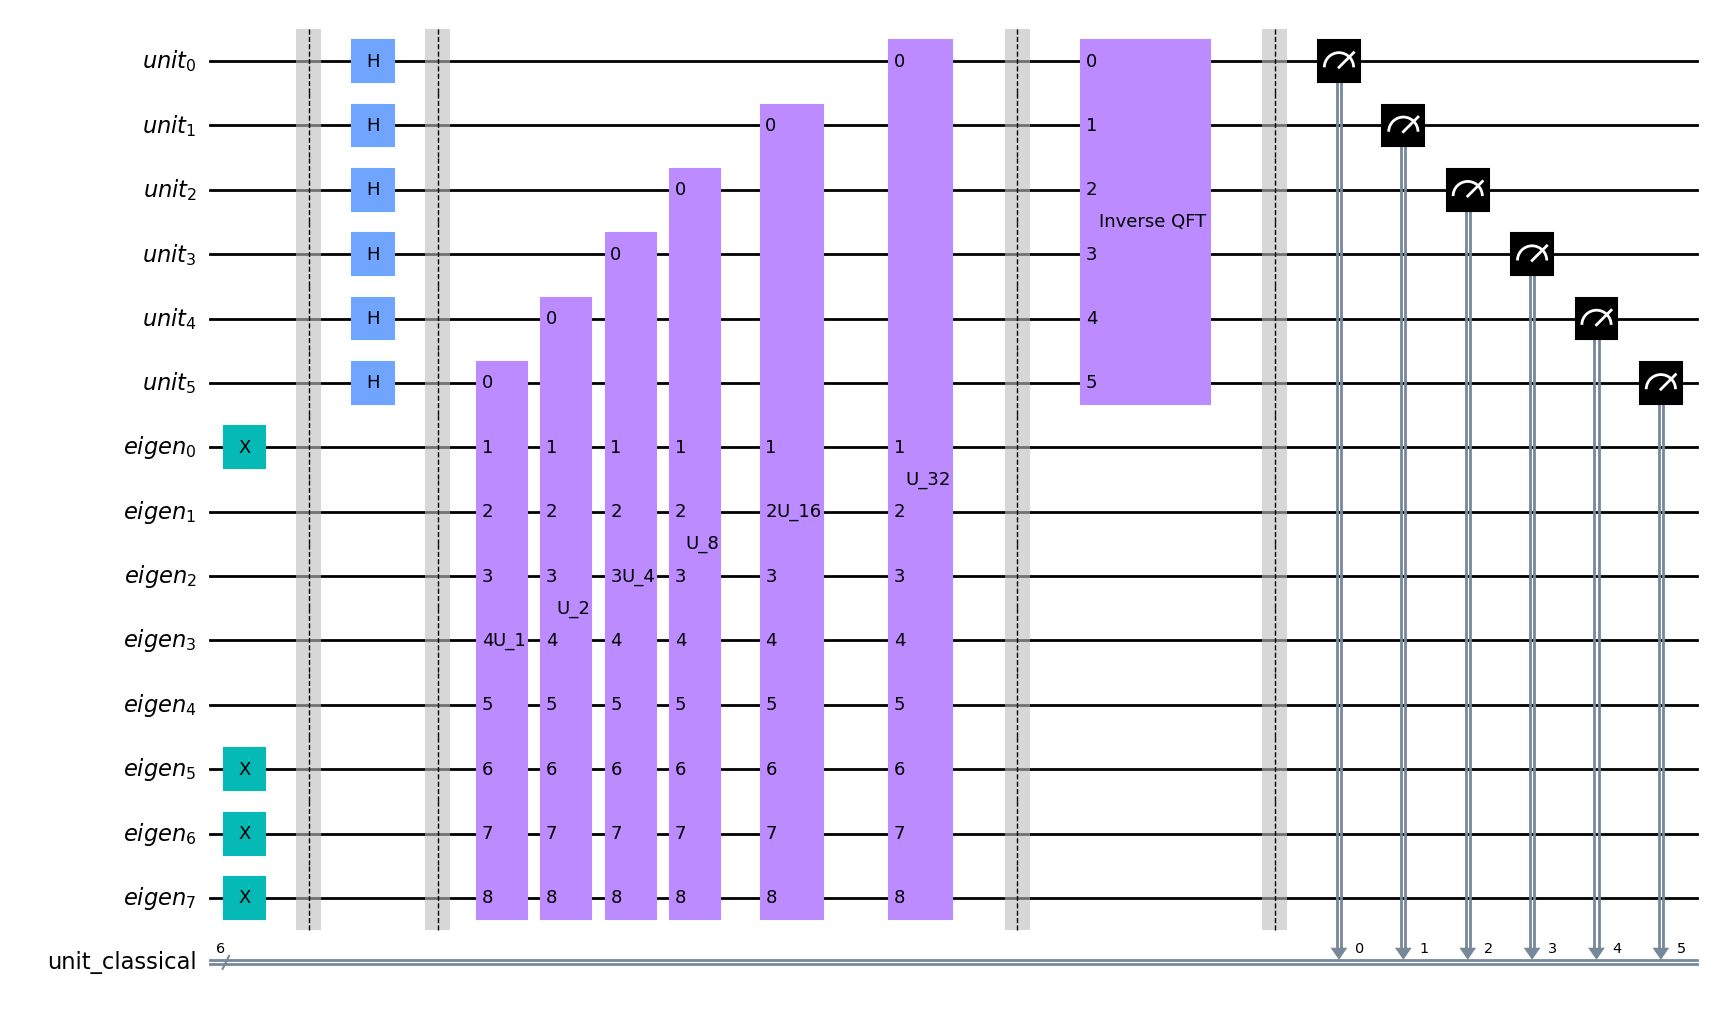

In [16]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 3)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i] ] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'011100': 8192}


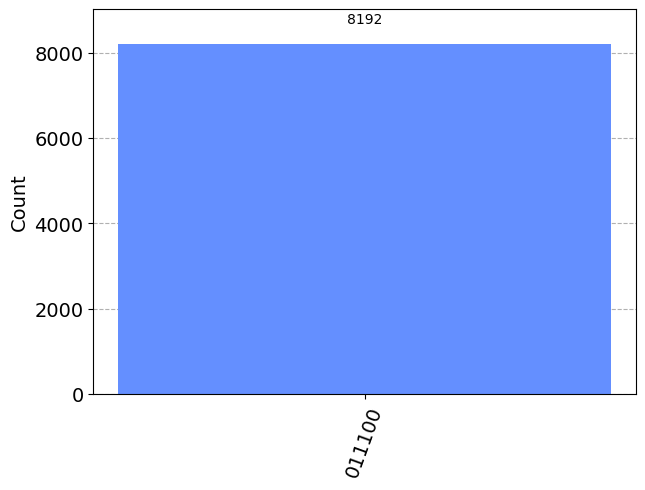

In [17]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)

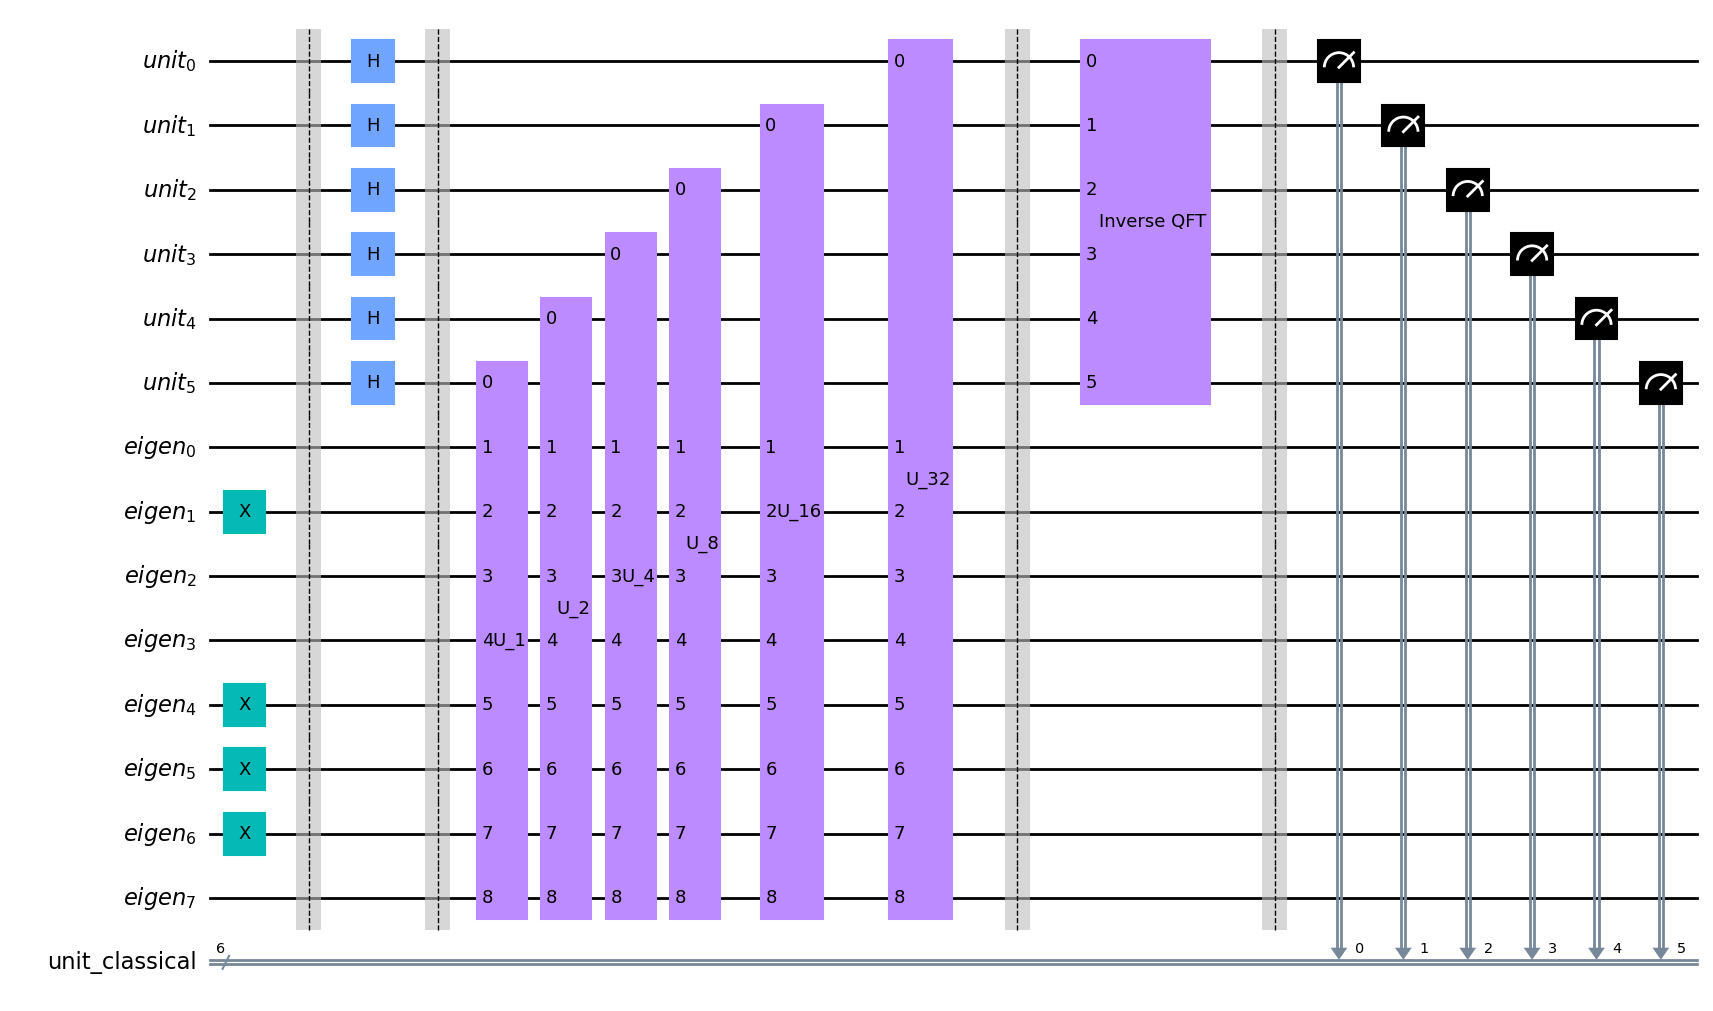

In [18]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 4)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i] ] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'101000': 8192}


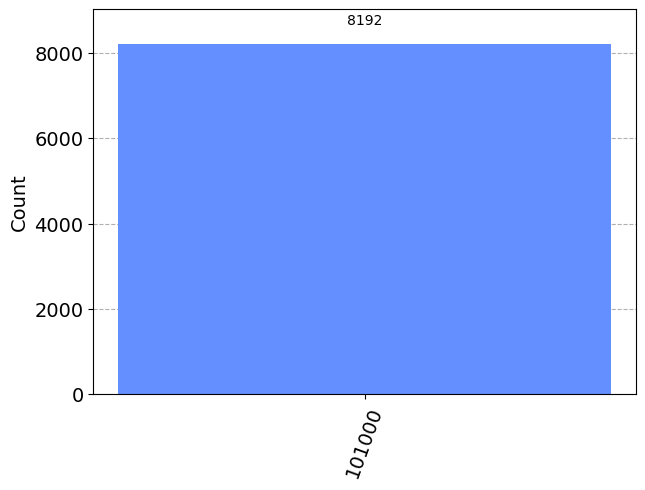

In [19]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)

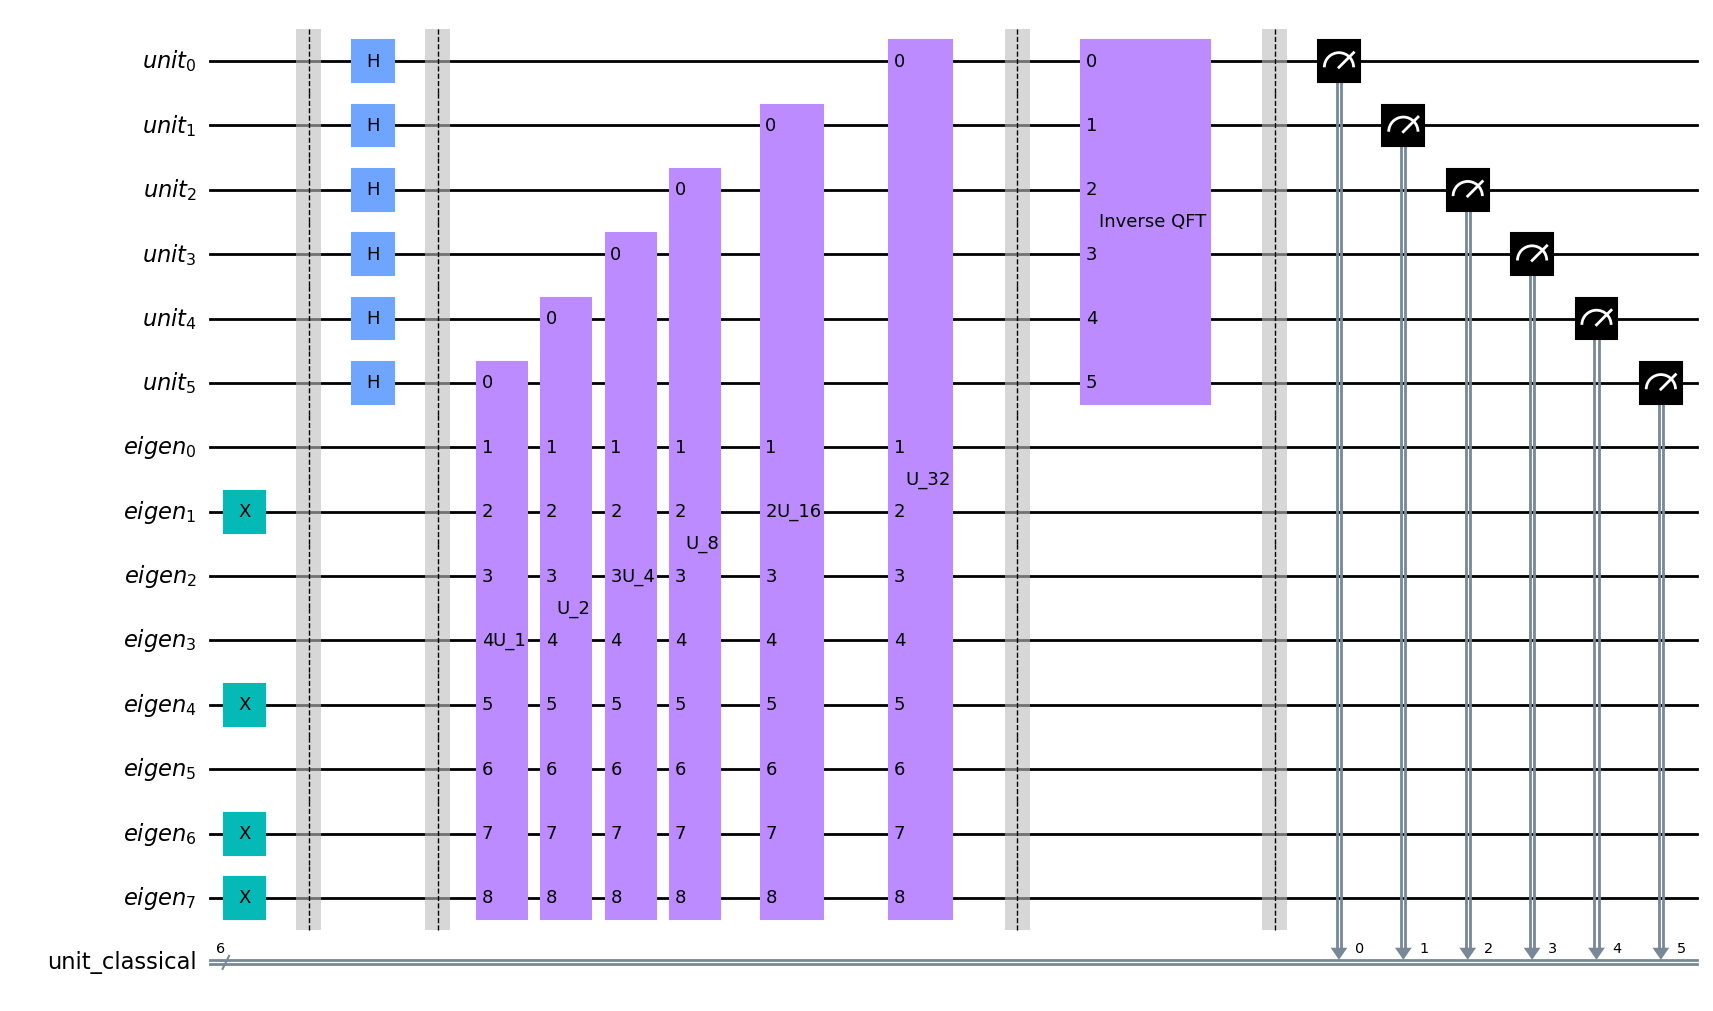

In [20]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# Playing with the first eigenstate here i.e. 11000110 from eigen_values list.
# (Try to play with other eigenstates from the eigen_values list)
eigenstates(qc, eigen, 5)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i] ] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

{'100000': 8192}


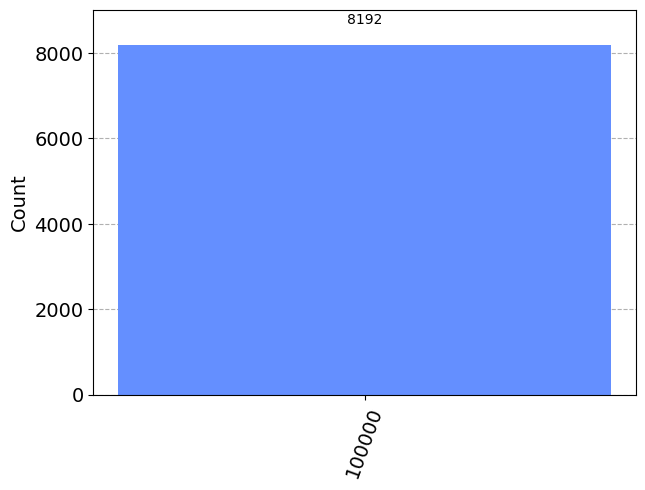

In [21]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)